# Introduction

This notebook demonstrates a workflow for loading, filtering, and visualizing change events data. The process involves the following steps:

1. **Setup and Configuration**: 
    - Import necessary modules and set the working directory to ensure paths are relative to the notebook's location.
    - Define input and output paths, along with a rule-based filtering configuration.

2. **Data Loading and Filtering**:
    - Load unlabelled change events from a JSON file.
    - Apply a rule-based filter to remove events that do not meet the specified criteria.
    - Save the filtered events to a new JSON file.

3. **Visualization**:
    - Compare the unfiltered and filtered datasets by plotting key features such as `change_mean` and `hull_volume`.

### Outputs:
- **Filtered Events File**: `../test_data/out/change_events_filtered_rule_based.json`
- **Plots**: Visualizations comparing unfiltered and filtered datasets.

This notebook provides a structured approach to preprocessing and analyzing change events data, making it easier to inspect and interpret the results.

# Imports & Working Directory
In order to ensure all imports are available and that paths are relative to this script’s location, we first import modules and set the working directory.

In [1]:
from aimon import ChangeEventCollection
import os
import matplotlib.pyplot as plt
from aimon import ProjectChange

# Set current directory to the location of the notebook (works even if __file__ is not defined)
try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

os.chdir(current_dir)


# Define Paths & Filtering Rule
To keep configuration centralized, we declare our input/output paths and the rule we’ll use to filter events. <br>

filter_rule = {
    "<feature_name>": {"min": <lower_bound>, "max": <upper_bound>},
    "<another_feature>": {"max": <upper_bound_only>}
}

In [3]:
# Path to the unlabelled change events and output folder
change_events_file = "../test_data/change_events_unlabelled.json"
outfolder          = "../test_data/out"
os.makedirs(outfolder, exist_ok=True)

filter_rule = {
    "change_mean": {"min": 5, "max": 10}
    }

# Where to save the filtered events
filtered_file = os.path.join(outfolder, 'change_events_filtered_rule_based.json')


# Load, Filter & Save Events
In order to apply our rule-based filter, we load all events into a collection, filter by filter_rule, then save the remaining events.

In [3]:
# Load all change events
coll = ChangeEventCollection().load_from_file(change_events_file)

# Convert to DataFrame and keep a copy of the unfiltered data
coll.to_dataframe()
unfiltered_df = coll.df

# Apply rule-based filtering
coll.events = coll.filter_events_rule_based(filter_rule)
# Save the filtered subset to JSON
coll.save_to_file(filtered_file)
_ = coll.to_dataframe()


# Visualize Unfiltered vs. Filtered
To inspect what was removed versus what remains, we re-generate the DataFrame on the filtered collection and plot both sets.

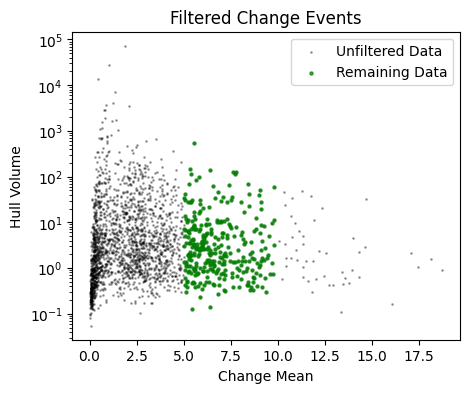

In [4]:
# Helper to plot a subset
def plot_events(df, event_type, color, alpha=0.7, size=5):
    subset = df[df['event_type'] == event_type]
    plt.scatter(
        subset['change_mean'],
        subset['hull_volume'],
        label=event_type.replace('_', ' ').title(),
        alpha=alpha,
        s=size,
        color=color
    )

# Tag the full (to‑be‑removed) and filtered DFs
unfiltered_labeled = unfiltered_df.assign(event_type='unfiltered_data')
filtered_labeled   = coll.df.assign(event_type='remaining_data')

plt.figure(figsize=(5, 4))
plot_events(unfiltered_labeled,   'unfiltered_data',   color='black', alpha=0.3, size=1)
plot_events(filtered_labeled,     'remaining_data', color='green',           size=5)

plt.yscale('log')
plt.legend()
plt.xlabel('Change Mean')
plt.ylabel('Hull Volume')
plt.title('Filtered Change Events')
plt.show()


# Project Changes into GIS Format
Finally, we wrap up by projecting our labelled events into GeoJSON using ProjectChange.

### Projecting and visualizing unfiltered data

In [ ]:
import git

predicted_file = os.path.join(outfolder, 'change_events_labelled_rule_based.json')

git_repo = git.Repo(current_dir, search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

img_path = os.path.join(git_root, "test_data/RangeImage.tif")
change_prj = ProjectChange(
    change_event_file       = predicted_file,
    project_name            = os.path.basename(predicted_file)[:-5],
    projected_image_path    = img_path,
    projected_events_folder = outfolder,
    epsg                    = 31254
)

change_prj.project_change()

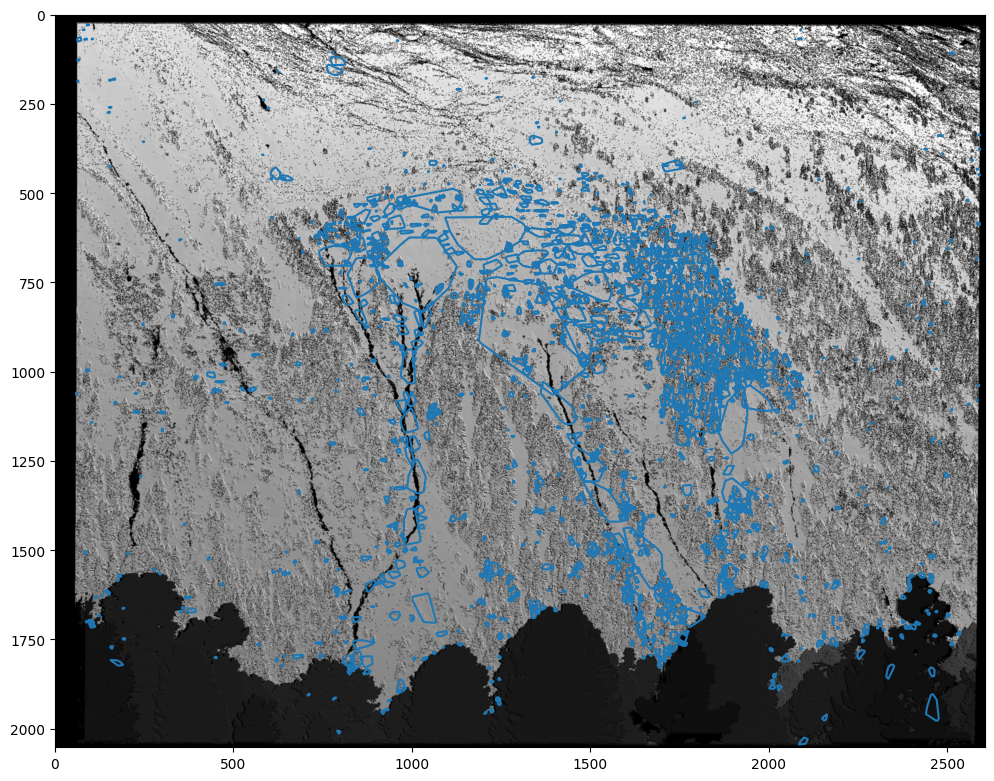

In [6]:
import geopandas as gpd
from matplotlib import pyplot as plt
import rasterio as rio
from rasterio.plot import show
import shapely

vector = "../test_data/out/change_events_labelled_rule_based_change_events_pixel.geojson"
raster = "../test_data/RangeImage.tif"  # UInt16 4 band in B G R NIR order

fig, ax = plt.subplots(1, figsize=(12, 12))

with rio.open(raster) as rds:
    show(
        (rds, (3, 2, 1)),  # Read 3 bands of raster in R G B order (3,2,1)
        adjust=True,       # Rescale 0.0 - 1.0
        ax=ax,             # Use existing matplotlib axes
    )

gdf = gpd.read_file(vector)
gdf = gpd.GeoSeries(gdf['geometry']).map(lambda polygon: shapely.ops.transform(lambda x, y: (x, -y), polygon))
gdf.boundary.plot(ax=ax)  # Plot just the boundary
plt.show()

### Projecting and visualizing filtered data

In [7]:
import git

git_repo = git.Repo(current_dir, search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

img_path = os.path.join(git_root, "test_data/RangeImage.tif")
change_prj = ProjectChange(
    change_event_file       = filtered_file,
    project_name            = os.path.basename(filtered_file)[:-5],
    projected_image_path    = img_path,
    projected_events_folder = outfolder,
    epsg                    = 31254
)

change_prj.project_change()

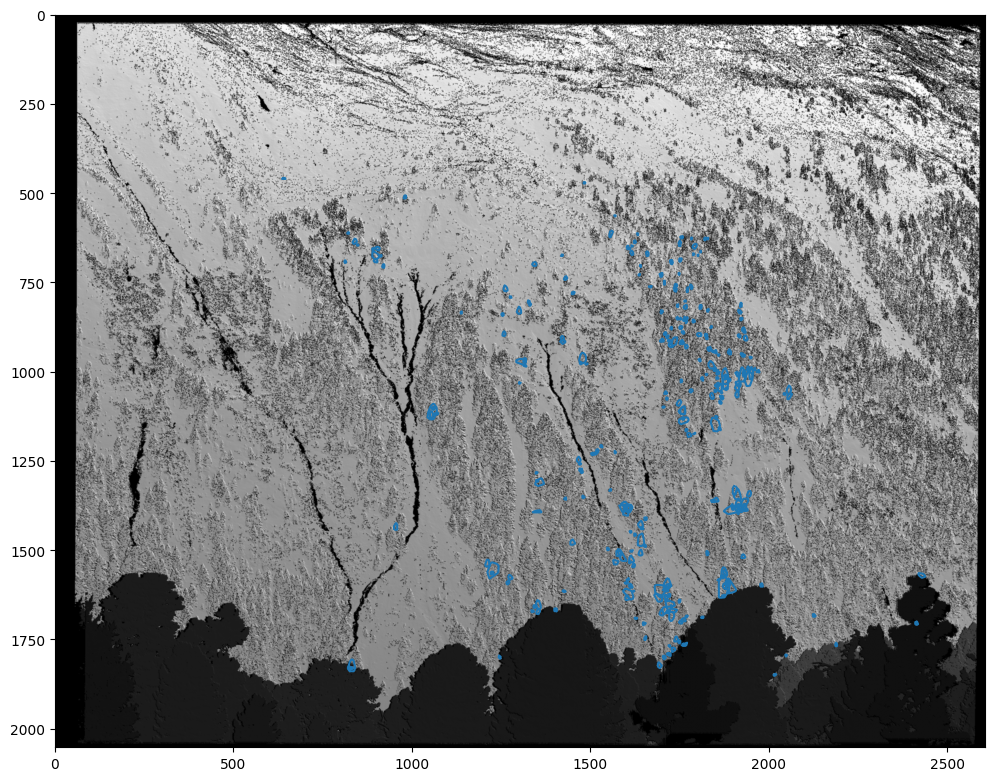

In [9]:
import geopandas as gpd
from matplotlib import pyplot as plt
import rasterio as rio
from rasterio.plot import show
import shapely

vector = "../test_data/out/change_events_filtered_rule_based_change_events_pixel.geojson"
raster = "../test_data/RangeImage.tif"  # UInt16 4 band in B G R NIR order

fig, ax = plt.subplots(1, figsize=(12, 12))

with rio.open(raster) as rds:
    show(
        (rds, (3, 2, 1)),  # Read 3 bands of raster in R G B order (3,2,1)
        adjust=True,       # Rescale 0.0 - 1.0
        ax=ax,             # Use existing matplotlib axes
    )

gdf = gpd.read_file(vector)
gdf = gpd.GeoSeries(gdf['geometry']).map(lambda polygon: shapely.ops.transform(lambda x, y: (x, -y), polygon))
gdf.boundary.plot(ax=ax)  # Plot just the boundary
plt.show()